# `NMF visualization`

Modified from the pyLDAvis scikit-learn example notebook.

In [1]:
import re, io, os
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict, OrderedDict
import urllib.request
import random
random.seed(13)

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, PCA
from sklearn.manifold import TSNE

import umap
import phate

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline
import seaborn as sns

## Helper Functions

In [3]:
def tokenize(data):
    index = defaultdict(str)
    
    with urllib.request.urlopen(data) as file:
        for line in file.read().decode('latin-1').splitlines():
            # pull out takahashi lines
            m = re.match(r'^<(f.*?)\..*;H> +(\S.*)$', line)
            if not m:
                continue

            transcription = m.group(2)
            pg = str(m.group(1))

            # ignore entire line if it has a {&NNN} or {&.} code
            if re.search(r'\{&(\d|\.)+\}', transcription):
                continue

            # remove extraneous chracters ! and %
            s = transcription.replace("!", "").replace("%", "")
            
            # delete all end of line {comments} (between one and three observed)
            # ...with optional line terminator
            # allow 0 occurences to remove end-of-line markers (- or =)
            s = re.sub(r'([-=]?\{[^\{\}]+?\}){0,3}[-=]?\s*$', "", s)

            # delete start of line {comments} (single or double)
            s = re.sub(r'^(\{[^\{\}]+?\}){1,2}', "", s)

            # simplification: tags preceeded by -= are word breaks
            s = re.sub(r'[-=]\{[^\{\}]+?\}', '.', s)

            # these tags are nulls
            # plant is a null in one case where it is just {plant}
            # otherwise (above) it is a word break
            # s = re.sub(r'\{(fold|crease|blot|&\w.?|plant)\}', "", s)
            # simplification: remaining tags in curly brackets
            s = re.sub(r'\{[^\{\}]+?\}', '', s)

            # special case .{\} is still a word break
            s = re.sub(r'\.\{\\\}', ".", s)

            # split on word boundaries
            # exclude null words ('')
            words = [str(w) for w in s.split(".") if w]
            paragraph = ' '.join(words).lstrip()
            
            index[pg] += (paragraph)

    return index


In [4]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

## Load Voynich Data

Load the Pickle files produced by vms_vectorize.py

In [5]:
models_path = "./models"

# load in the pickle files of stored models
with open("{}/tfidf_vectorizer.pk".format(models_path), "rb") as f:
    tfidf_vectorizer = pickle.load(f)
with open("{}/vms_tf.pk".format(models_path), "rb") as f:
    vms_tf = pickle.load(f)
with open("{}/vms_mapping.pk".format(models_path), "rb") as f:
    vms_mapping = pickle.load(f)
with open("{}/tf_vectorizer.pk".format(models_path), "rb") as f:
    tf_vectorizer = pickle.load(f)
with open("{}/vms_tfidf.pk".format(models_path), "rb") as f:
    vms_tfidf = pickle.load(f)

index = tokenize("https://raw.githubusercontent.com/rachelbari/voynich-topic-modeling/master/data/text16e6.evt")
documents = [index[key] for key in index.keys()]


/home/annie/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/annie/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/annie/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


#### Make a dict containing information about each page of the VMS

In [10]:
# a class for a single folio
# currently just contains state variables
# will eventually have a show() method to display the page
class Folio:
    def __init__(self, name, quire, topic="?", hand=0, lang="?"):
        self.name = name
        self.quire = int(quire)
        self.topic = topic
        self.hand = int(hand)
        self.lang = lang
        self.topic_color = "C1"
        self.lang_color = "C0"

In [21]:
lfd_map = pd.read_csv("./lfd_map.csv")
print(lfd_map)
vms = OrderedDict()
topic_dict = {}
lang_dict = {}
topic_color = []
lang_color = []
for row in lfd_map.iterrows():
    # declare the folio object
    folio = Folio(row[1].folio, row[1].quire, row[1].topic, row[1].hand, row[1].language)
    
    # set up the topic color
    if not row[1].topic in topic_dict.keys():
        topic_dict[row[1].topic] = "C"+str(len(topic_dict))
    folio.topic_color = topic_dict[folio.topic]
    topic_color.append(folio.topic_color)    
    print(topic_dict[folio.topic])
    
    # set up the language color
    if not row[1].language in lang_dict.keys():
        lang_dict[row[1].language] = "C"+str(len(lang_dict))
    folio.lang_color = lang_dict[folio.lang]
    lang_color.append(folio.lang_color)    
    print(lang_dict[folio.lang])
    
    vms[folio.name] = folio

vms_df = lfd_map.assign(topic_color = topic_color)
vms_df = vms_df.assign(lang_color = lang_color)

print(vms_df)
print(type(lfd_map))
print(list(vms.items())[0][1].topic_color)
#print(vms['f1v'])


     folio               topic  hand language  quire
0      f1r           botanical     1        a      1
1      f1v           botanical     1        a      1
2      f2r           botanical     1        a      1
3      f2v           botanical     1        a      1
4      f3r           botanical     1        a      1
..     ...                 ...   ...      ...    ...
220  f114r  starred paragraphs     3        b     18
221  f114v  starred paragraphs     3        b     18
222  f115r  starred paragraphs     3        b     18
223  f115v  starred paragraphs     3        b     18
224  f116r  starred paragraphs     3        b     18

[225 rows x 5 columns]
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C1
C0
C1
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C

## Fit NMF models

In [22]:
# for TF
#nmf_tf = LatentDirichletAllocation(n_topics=num_topics, random_state=0, max_iter=8)#, learning_method="online", learning_offset=20.)
#nmf_tf.fit(vms_tf)
# for TFIDF
num_topics = 4

# reset the topic labels
for key in vms.keys():
    vms[key].nmf_topic = 0

nmf_tfidf = NMF(n_components=num_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf_tfidf.fit(vms_tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf_tfidf, tfidf_feature_names, 10)

nmf_embedding = nmf_tfidf.transform(vms_tfidf)
nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

# assign each page to its nearest topic, and log that in the vms dict
i = 0
topic_col = []
for topic in nmf_embedding.argmax(axis=1):
    name = lfd_map['folio'].values[i]
    vms[name].nmf_topic = topic
    topic_col.append(topic)
    i += 1
lfd_map = lfd_map.assign(topic_nmf = topic_col)

lfd_map.to_csv("./out/nmf_"+str(num_topics)+"_map.csv")


Topic #0:
shedy chedy qokeedy qokain qokedy ol qokeey qol qokal shey

Topic #1:
daiin chol chor chy shol cthy sho shor dain cthor

Topic #2:
aiin ar al or okaiin okar chdy otaiin chedy qokaiin

Topic #3:
okeol cheol ol qokeol or cheor daiin chol okeey ckhey



## Making sense of the data

Using techniques from https://www.kaggle.com/xdsarkar/nips-papers-visualized-with-nmf-and-t-sne

First, we transform the tfidf-matrix into an nmf-embedding, and look at which folios are most closely associated with each topic

In [23]:
top_n = 20 #how many pages

top_idx = np.argsort(nmf_embedding,axis=0)[-top_n:]

print(top_idx.T)

# output into a file
outfile = open('./out/map_'+str(num_topics)+'_topics_top_'+str(top_n)+'.txt', 'w') 

count = 0
for idxs in top_idx.T: 
    print("\nTopic {}:".format(count))
    print("\nTopic {}:".format(count), file=outfile)
    for idx in np.flip(idxs): # they're in reverse order
        folio = vms_mapping[idx]
        # print twice to get both file output and stdout in the notebook
        print("("+str(vms[folio].nmf_topic)+") "+folio+": hand "+str(vms[folio].hand)+", language "+vms[folio].lang+", "+vms[folio].topic)
        print("("+str(vms[folio].nmf_topic)+") "+folio+": hand "+str(vms[folio].hand)+", language "+vms[folio].lang+", "+vms[folio].topic, file=outfile)
    count += 1
outfile.close()


[[155 203 150 154 160 156 151 163 158 153 202 145 146 147 161 162 148 159
  149 144]
 [109   0   9  40  19  50  53  15  35  26  34  37  17   6  95  61  80  18
   27  90]
 [ 62  76 218 128 206 136 131 211 216  63 220 204 167 209 210 107  75 207
  168 219]
 [181  98 180 174 173 194 177 190  31 198 172 195 192 197 193 200 199 201
  175 196]]

Topic 0:
(0) f75r: hand 2, language b, balneological
(0) f77v: hand 2, language b, balneological
(0) f82v: hand 2, language b, balneological
(0) f77r: hand 2, language b, balneological
(0) f84r: hand 2, language b, balneological
(0) f83v: hand 2, language b, balneological
(0) f76v: hand 2, language b, balneological
(0) f76r: hand 2, language b, balneological
(0) f75v: hand 2, language b, balneological
(0) f103r: hand 3, language b, starred paragraphs
(0) f79v: hand 2, language b, balneological
(0) f82r: hand 2, language b, balneological
(0) f84v: hand 2, language b, balneological
(0) f78v: hand 2, language b, balneological
(0) f81r: hand 2, language 

## Visualize the results with various dimension reduction methods

In [31]:
# get the colors to put in the legend
topic_legend, topics = [], []
lang_legend, langs = [], []
for i in range(len(topic_dict)): 
    topic_legend.append(mpatches.Ellipse((0,0), 1, 1, fc=list(topic_dict.values())[i]))
    topics.append(list(topic_dict.keys())[i])
for i in range(len(lang_dict)): 
    lang_legend.append(mpatches.Ellipse((0,0), 1, 1, fc=list(lang_dict.values())[i]))
    langs.append(list(lang_dict.keys())[i])



In [98]:
# general visualization method
def visualize(embedding, color_code, method, save=False, perplexity=20, decay=5, knn=3, n_neighbors=20, min_dist=0.001):
    method = str.lower(method)
    transformer = []
    dim_reduced = []
    
    if (method == "tsne" or method == "t-sne"):
        print("using tSNE")
        tsne = TSNE(perplexity=perplexity, n_iter=50000)
        dim_reduced = tsne.fit_transform(embedding)
    elif method == "umap":
        print("using UMAP")
        UMAP = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2)
        dim_reduced = UMAP.fit_transform(embedding)
    elif method == "pca":
        print("using PCA")
        pca = PCA(n_components=2)
        dim_reduced = pca.fit_transform(embedding)
    elif method == "phate":
        print("using PHATE")
        PHATE = phate.PHATE(decay=decay, knn=knn)
        dim_reduced = PHATE.fit_transform(embedding)

    else:
        print("Error: unknown dimension reduction method")
        return -1
        
    x_axis=dim_reduced[:,0]
    y_axis=dim_reduced[:,1]
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()
    ax.axis('off')
    plt.title("VMS clustering: "+str(num_topics)+"-topic NMF, visualized with "+method)
    
    if color_code == 'topic':
        ax.scatter(x=x_axis, y=y_axis, s=8, c=vms_df['topic_color'].values)
        fig.legend(topic_legend, topics, loc=(0.1, 0.69))
    elif color_code == 'lang':
        ax.scatter(x=x_axis, y=y_axis, s=8, c=vms_df['lang_color'].values)
        fig.legend(lang_legend, langs, loc=(0.1, 0.69))
    #TODO save
    plt.show()
    

## Visualize things!
The visualize method supports t-SNE, UMAP, PCA, and PHATE

#### t-SNE
t-SNE is one of the standard dimension reduction methods, and is good overall, but is highly dependent on the settings of its hyperparameters.
t-SNE generally does well with this data set, using perplexity of 15-25. 
It produces several distinct topic clusters, including one primerily balneological cluster and one primerily recipies cluster. 
The languages are well-separated, but appear to be part of one continuous distribution, rather than independent clusters.

#### UMAP
UMAP is a newer dimension reduction methods that makes some assumptions about the data - namely that it is made of a collection of locally connected manifolds, ie, that it is a collection of well-formed clusters.
UMAP performs similarly to t-SNE on this data. 
It produces the same recipie and balneological clusters as t-SNE, and splits the language B botanical topic into a mostly separate cluster.

#### PCA
Principal Component Analysis is the oldest dimension reduction method.
It does very, very poorly on this data.
It manages to put language A on one side of the plot and language B on the other, but does not produce any of the distinct topic clusters that other methods produce

#### PHATE
PHATE is a very new method developed by a group at Yale for clustering RNA data.
It is designed to retain tree-like structures in data that have them, and as such is probably biased towards producing them in data without tree-like structures.
It does, in fact, produce a tree-like structure in our data. 
Using a knn of 4-6, we get a tree with 3 branches, with the left branch being language B, and the right two branches being language A.
The top of the left two branches is separated, and corresponds to the balneological and recipie clusters.
This is an interesting visualization, but given the lack of computational linguistics work using PHATE, I am unable to make sense of what this tree structure means.



using PHATE
Calculating PHATE...
  Running PHATE on 225 cells and 4 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
  Calculated optimal t in 0.01 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.10 seconds.
Calculated PHATE in 0.13 seconds.


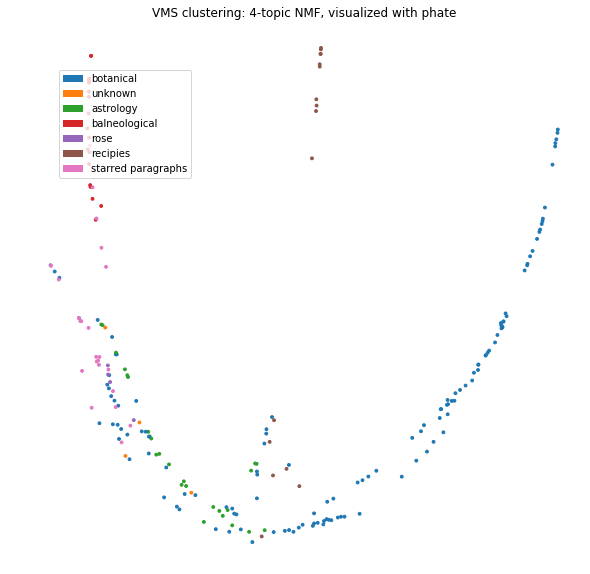

In [113]:
#visualize(nmf_embedding, color_code='lang', method='tsne', perplexity = 15)
#visualize(nmf_embedding, color_code = 'lang', method='umap', n_neighbors=20)
#visualize(nmf_embedding, color_code='topic', method='pca')
visualize(nmf_embedding, color_code = 'topic', method='phate', decay=5, knn=4)